# Script to make a phase diagram to illustrate loss vs input sparsity vs training sparsity for 
# different toy models

In [1]:
# Set up notebook

"""Import necessary packages"""

%load_ext autoreload
%autoreload 2

import os
from dataclasses import dataclass, field
from typing import Callable, List, Optional, Tuple, Union

import matplotlib as mpl
import numpy as np
import pandas as pd
import torch as t
import matplotlib.pyplot as plt

from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go
from plotly import io as pio
from rich import print as rprint
import seaborn as sns
from torch import nn, optim, Tensor
from torch.nn import functional as F
from tqdm.notebook import tqdm

from toy_cis.models import CisConfig, Cis
from toy_cis.plot import plot_weight_bars, plot_input_output_response
from toy_cis.util import threshold_matrix, in_out_response

"""Set KMP_DUPLICATE_LIB_OK=TRUE to avoid MKL errors when plotting with mpl"""

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
plt.rcParams.update({"font.size": 16})

"""Set torch device."""

device = t.device("cuda" if t.cuda.is_available() else "cpu")
# device = t.device("cpu")  # small toy models have lower loss and are faster via cpu
device_name = t.cuda.get_device_name(0) if t.cuda.is_available() else "cpu"
print(f"{device_name=}")

device_name='NVIDIA A40'


In [2]:
"""Create functions for generating batches, loss, and training."""

def gen_batch(model: Cis, batch_sz: int, sparsity: float | Float[Tensor, "inst feat"]) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, x + t.relu(x)

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    n_steps: int,
    lr: float,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []
    
    optimizer = t.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    
    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        
        # Update the learning rate
        current_lr = lr * np.cos(0.5 * np.pi * step / (n_steps - 1))
        for param_group in optimizer.param_groups:
            param_group["lr"] = current_lr
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

## 1. *ReLU_PlusX with Identity Embedding (= no embedding)*

Target: 
$$
y = x + ReLU(x)
$$

Linear map: 

$$
h = ReLU(W_1x)$$
$$
y' = W_2h + x
$$

Input (sparsity=0.99, so feature_probability=0.01 for each feature on each example):

$$
x = \text{rand}(-1, 1)
$$

Loss (mse):

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} \left(y_i - y_{\text{true},i}\right)^2 \\[2ex]
$$

In [12]:
"""Initialize model."""

layer_act_fns = [t.relu, lambda x: x]

num_features = 100
reluPlusX_res_noEmbed_cfg = CisConfig(
    n_instances=1,
    n_feat=num_features,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=False,
)

In [15]:
""" Train and test over a wide range of sparsities"""

sparsities = np.array([0.1, 0.3, 0.5, 0.75, 0.90, 0.95, 0.99])
feat_importance = 1
lr = 3e-3
n_steps = 10000
logging_freq = n_steps // 10
batch_sz = 1024

# iterate over sparsities for training and test at all sparsity levels
loss_data = []
poly_data = []
for spar in sparsities: 
    
    """Train model at a certain sparsity"""
    
    reluPlusX_res_noEmbed_cis = Cis(reluPlusX_res_noEmbed_cfg, device=device).to(device)

    if spar >= 0.9:
        n_steps = 10000
    feat_sparsity = spar
    
    losses = train(
            reluPlusX_res_noEmbed_cis,
            batch_sz,
            feat_sparsity,
            feat_importance,
            loss_fn,
            n_steps,
            lr, 
            logging_freq
    )
    display(losses)

    """Get loss at inference over varying sparsity levels."""
    logging_freq = n_steps // 10


    pbar = tqdm(sparsities, desc="Testing over sparsities")
    n_examples = 10000
    
    for s in pbar:
    
        with t.no_grad():
            # generate examples of inputs
            x, y_true = gen_batch(reluPlusX_res_noEmbed_cis, n_examples, s)
            
            # compute mean loss
            y = reluPlusX_res_noEmbed_cis.forward(x)
            active_weight, inactive_weight = 10, 1
            weights = t.where(y_true == 1, active_weight, inactive_weight)
            loss = weights * (y - y_true) ** 2
            
            # store loss at sparsity level
            loss = rearrange(loss, "examples 1 features -> examples features")
            loss = asnumpy(reduce(loss, "examples features -> features", "mean"))
            for feat_idx, val in enumerate(loss):
                loss_data.append({"train_sparsity":spar, "input_sparsity": s, "feature_idx": feat_idx, "loss_per_feature": val})
    
    """Get polysemanticity level as number of features per neuron"""
    W = einsum(reluPlusX_res_noEmbed_cis.W1, reluPlusX_res_noEmbed_cis.W2, "inst neuron feature, inst feature neuron-> neuron feature")
    W = threshold_matrix(W.squeeze(), threshold=0.001)
    features_per_neuron = np.sum(W.cpu().detach().numpy() > 0.001, axis= 1) / num_features
    poly_data.append({"train_sparsity": spar, "features_per_neuron": features_per_neuron})
    

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

[0.15114206075668335,
 0.0715814083814621,
 0.07105507701635361,
 0.07094019651412964,
 0.07003985345363617,
 0.06615860760211945,
 0.06035799905657768,
 0.0537392683327198,
 0.0509597584605217,
 0.0509868860244751,
 0.05074501037597656]

Testing over sparsities:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

[0.11946907639503479,
 0.0656830221414566,
 0.06360574066638947,
 0.06349796056747437,
 0.06072831526398659,
 0.05831725150346756,
 0.052199315279722214,
 0.04936213046312332,
 0.04870405048131943,
 0.04691570997238159,
 0.045784901827573776]

Testing over sparsities:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

[0.08243334293365479,
 0.052211351692676544,
 0.05027138441801071,
 0.050168268382549286,
 0.045734260231256485,
 0.040012530982494354,
 0.03711797297000885,
 0.03621638938784599,
 0.03584772348403931,
 0.03518820181488991,
 0.03476555272936821]

Testing over sparsities:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

[0.04293084889650345,
 0.028964320197701454,
 0.027799377217888832,
 0.025530211627483368,
 0.023101747035980225,
 0.020283708348870277,
 0.020049218088388443,
 0.01992853172123432,
 0.019350120797753334,
 0.019872775301337242,
 0.019947804510593414]

Testing over sparsities:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

[0.01599370874464512,
 0.01106447447091341,
 0.011152025312185287,
 0.010307807475328445,
 0.009167634882032871,
 0.009485767222940922,
 0.008645080961287022,
 0.00872779916971922,
 0.008834509178996086,
 0.008207195438444614,
 0.00852588377892971,
 0.008099919185042381,
 0.009112696163356304,
 0.008322853595018387,
 0.008194291964173317,
 0.00823702197521925,
 0.008556236512959003,
 0.008221521973609924,
 0.009073390625417233,
 0.007729755248874426,
 0.008640695363283157,
 0.008497272618114948,
 0.007611264940351248,
 0.008426067419350147,
 0.00826294906437397,
 0.009134083054959774,
 0.008699493482708931,
 0.00785780604928732,
 0.007925032638013363,
 0.008058206178247929,
 0.008649127557873726,
 0.008457803167402744,
 0.007827936671674252,
 0.008837807923555374,
 0.007391096092760563,
 0.00881279818713665,
 0.008068349212408066,
 0.008386924862861633,
 0.008688842877745628,
 0.007876934483647346,
 0.008343002758920193,
 0.007966780103743076,
 0.007770467083901167,
 0.0074146580882370

Testing over sparsities:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

[0.0085649024695158,
 0.004467027261853218,
 0.00448616174980998,
 0.004472917877137661,
 0.0038769978564232588,
 0.004044762346893549,
 0.004216988105326891,
 0.0037753188516944647,
 0.004367537796497345,
 0.004006694070994854,
 0.004360808525234461]

Testing over sparsities:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

[0.0015351157635450363,
 0.0007964573451317847,
 0.0007858663448132575,
 0.0009299911907874048,
 0.0009883854072540998,
 0.0008900606189854443,
 0.0008184341131709516,
 0.0009615400340408087,
 0.0007872111746110022,
 0.0008814214961603284,
 0.0006864367751404643]

Testing over sparsities:   0%|          | 0/7 [00:00<?, ?it/s]

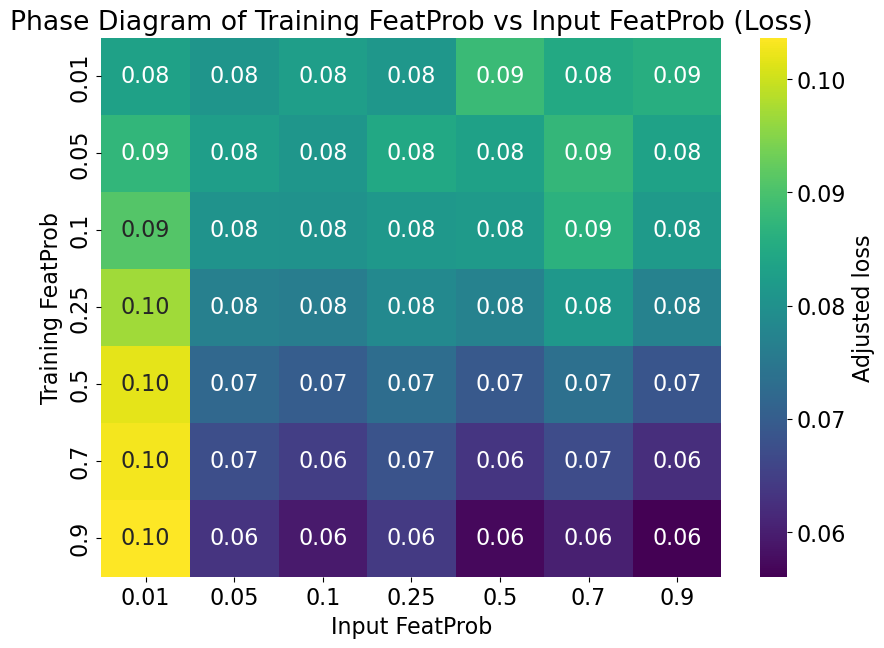

<Figure size 640x480 with 0 Axes>

In [38]:
"""Plot phase diagram"""
loss = pd.DataFrame(loss_data)

# Aggregate loss_per_feature over feature_idx
loss_avg = loss.groupby(["train_sparsity", "input_sparsity"])["loss_per_feature"].mean().reset_index()
loss_avg["input_probs"] = np.round(1 - loss_avg["input_sparsity"],2)
loss_avg["training_probs"] = np.round(1 - loss_avg["train_sparsity"],2)
loss_avg["loss/1-S"] = loss_avg["loss_per_feature"] / (1 - loss_avg["input_sparsity"])

# Create pivot table for heatmap
pivot_table = loss_avg.pivot(index="input_probs", columns="training_probs", values="loss/1-S")

# Plot phase diagram
plt.figure(figsize=(10, 7))
sns.heatmap(pivot_table, cmap="viridis", annot=True, fmt=".2f", cbar_kws={'label': 'Adjusted loss'})

plt.xlabel("Input FeatProb")
plt.ylabel("Training FeatProb")
plt.title("Phase Diagram of Training FeatProb vs Input FeatProb (Loss)")
plt.savefig("/workspace/phaseDiagram_loss_identityEmbed.png", dpi=300)
plt.show()

# Show plot
plt.savefig("/workspace/phaseDiagram_loss_identityEmbed.png", dpi=300)
plt.show()

In [39]:
"""Plot phase diagram of training steps vs training sparsity and polysemanticity/loss"""
sparsities = np.array([0.1, 0.3, 0.5, 0.75, 0.90, 0.95, 0.99])
steps = np.array([10000, 30000, 50000, 80000, 120000, 150000, 180000])
feat_importance = 1
lr = 3e-3
batch_sz = 1024


# iterate over sparsities for training and test at all sparsity levels
loss_data = []
poly_data = []
for spar in sparsities: 
    
    """Train model at a certain sparsity"""

    for n_steps in steps: 
        logging_freq = n_steps // 10
        reluPlusX_res_noEmbed_cis = Cis(reluPlusX_res_noEmbed_cfg, device=device).to(device)
    
        if spar >= 0.9:
            n_steps = 10000
        feat_sparsity = spar
        
        losses = train(
                reluPlusX_res_noEmbed_cis,
                batch_sz,
                feat_sparsity,
                feat_importance,
                loss_fn,
                n_steps,
                lr, 
                logging_freq
        )
            
        """Get loss at inference over varying sparsity levels."""
        pbar = tqdm(sparsities, desc="Testing over sparsities")
        n_examples = 10000
        
        for s in pbar:
        
            with t.no_grad():
                # generate examples of inputs
                x, y_true = gen_batch(reluPlusX_res_noEmbed_cis, n_examples, s)
                
                # compute mean loss
                y = reluPlusX_res_noEmbed_cis.forward(x)
                active_weight, inactive_weight = 10, 1
                weights = t.where(y_true == 1, active_weight, inactive_weight)
                loss = weights * (y - y_true) ** 2
                
                # store loss at sparsity level
                loss = rearrange(loss, "examples 1 features -> examples features")
                loss = asnumpy(reduce(loss, "examples features -> features", "mean"))
                for feat_idx, val in enumerate(loss):
                    loss_data.append({"train_sparsity":spar, "steps": n_steps, "input_sparsity": s, "feature_idx": feat_idx, "loss_per_feature": val})
        
        """Get polysemanticity level as number of features per neuron"""
        W = einsum(reluPlusX_res_noEmbed_cis.W1, reluPlusX_res_noEmbed_cis.W2, "inst neuron feature, inst feature neuron-> neuron feature")
        W = threshold_matrix(W.squeeze(), threshold=0.001)
        features_per_neuron = np.sum(W.cpu().detach().numpy() > 0.001, axis= 1) / num_features
        poly_data.append({"train_sparsity": spar, "steps": n_steps, "features_per_neuron": features_per_neuron})
        

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Testing over sparsities:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/30000 [00:00<?, ?it/s]

Testing over sparsities:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

KeyboardInterrupt: 

## 2. *ReLU_PlusX with Random Embedding*

Target: 
$$
y = x + ReLU(x)
$$

Linear map: 

$$
e = W_e x$$
$$h = ReLU(W_1 e)$$
$$u = W_2 h + x$$
$$y' = W_u u
$$

Input (sparsity=0.99, so feature_probability=0.01 for each feature on each example):

$$
x = \text{rand}(-1, 1) \\
$$

Loss (mse):

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} \left(y_i - y_{\text{true},i}\right)^2 \\[2ex]
$$

In [6]:
"""Initialize model."""

layer_act_fns = [t.relu, lambda x: x]

reluPlusX_res_embed_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=True,
    We_dim=1000
)

In [7]:
""" Train and test over a wide range of sparsities"""

sparsities = np.array([0.1, 0.3, 0.5, 0.75, 0.90, 0.95, 0.99])
feat_importance = 1
lr = 3e-3
n_steps = 10000
logging_freq = n_steps // 10
batch_sz = 1024

# iterate over sparsities for training and test at all sparsity levels
loss_data = []
for spar in sparsities: 
    """Train model at a certain sparsity"""
    
    reluPlusX_res_embed_cis = Cis(reluPlusX_res_embed_cfg, device=device)
    
    feat_sparsity = spar
    
    losses = train(
        reluPlusX_res_embed_cis,
        batch_sz,
        feat_sparsity,
        feat_importance,
        loss_fn,
        n_steps,
        lr, 
        logging_freq
    )
    display(losses)

    """Get loss at inference over varying sparsity levels."""


    batch_sz = 256
    feat_importance = 1
    logging_freq = n_steps // 10


    pbar = tqdm(sparsities, desc="Testing over sparsities")
    n_examples = 10000
    
    for s in pbar:
    
        with t.no_grad():
            # generate examples of inputs
            x, y_true = gen_batch(reluPlusX_res_embed_cis, n_examples, s)
            
            # compute mean loss
            y = reluPlusX_res_embed_cis.forward(x)
            active_weight, inactive_weight = 10, 1
            weights = t.where(y_true == 1, active_weight, inactive_weight)
            loss = weights * (y - y_true) ** 2
            
            # store loss at sparsity level
            loss = rearrange(loss, "examples 1 features -> examples features")
            loss = asnumpy(reduce(loss, "examples features -> features", "mean"))
            for feat_idx, val in enumerate(loss):
                loss_data.append({"train_sparsity":spar, "input_sparsity": s, "feature_idx": feat_idx, "loss_per_feature": val})


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

[0.181561678647995,
 0.052816085517406464,
 0.05212065950036049,
 0.051877718418836594,
 0.05223052203655243,
 0.05192575231194496,
 0.052149008959531784,
 0.05200623720884323,
 0.052119940519332886,
 0.05205444246530533,
 0.05192285403609276]

Testing over sparsities:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

[0.14014621078968048,
 0.04673710837960243,
 0.0477142408490181,
 0.047541722655296326,
 0.04745364561676979,
 0.04660414531826973,
 0.04755720868706703,
 0.047235727310180664,
 0.046686768531799316,
 0.04568842798471451,
 0.047089941799640656]

Testing over sparsities:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

[0.09806419163942337,
 0.03778613358736038,
 0.03709246963262558,
 0.036694154143333435,
 0.036810122430324554,
 0.03651607036590576,
 0.03690628334879875,
 0.036938659846782684,
 0.036971576511859894,
 0.03616636246442795,
 0.03616255149245262]

Testing over sparsities:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

[0.051948145031929016,
 0.020330660045146942,
 0.02018989995121956,
 0.019517675042152405,
 0.019551217555999756,
 0.020781831815838814,
 0.020763898268342018,
 0.01929221674799919,
 0.01908816024661064,
 0.019161256030201912,
 0.01992417313158512]

Testing over sparsities:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

[0.020862633362412453,
 0.008131874725222588,
 0.0081997225061059,
 0.007827943190932274,
 0.007853541523218155,
 0.007966200821101665,
 0.008160189725458622,
 0.007790553383529186,
 0.007398118730634451,
 0.0077027129009366035,
 0.007678639143705368]

Testing over sparsities:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

[0.009782878682017326,
 0.00412447564303875,
 0.0038639353588223457,
 0.003745216643437743,
 0.003890089225023985,
 0.003970597870647907,
 0.0036709958221763372,
 0.003623443190008402,
 0.0038824097719043493,
 0.0036733399610966444,
 0.0034845243208110332]

Testing over sparsities:   0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

[0.0020009102299809456,
 0.0007621991680935025,
 0.0007444851798936725,
 0.0007501689833588898,
 0.0006739521049894392,
 0.000770778045989573,
 0.000582273059990257,
 0.0006532664410769939,
 0.0005041322438046336,
 0.0006865531322546303,
 0.0007503791130147874]

Testing over sparsities:   0%|          | 0/7 [00:00<?, ?it/s]

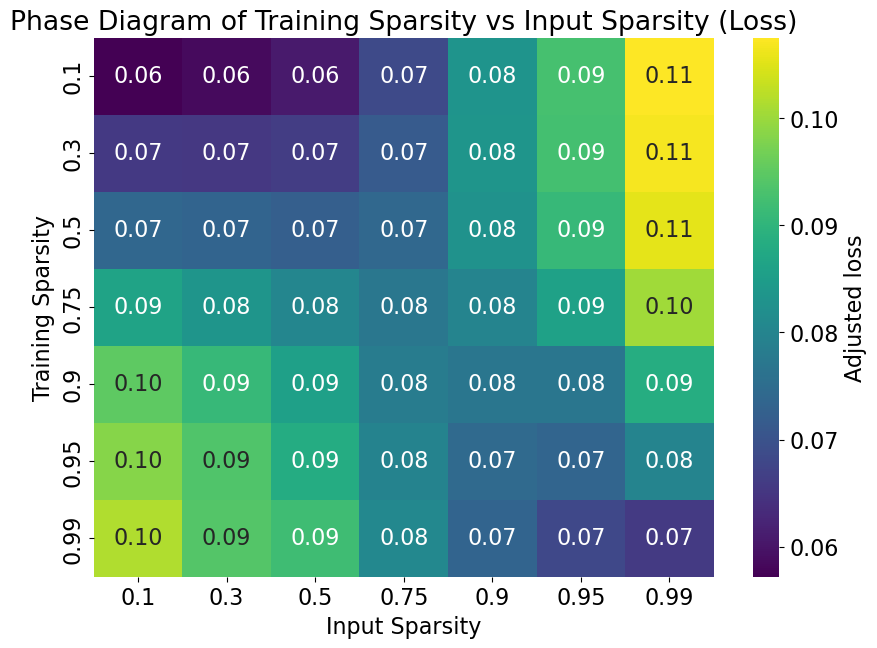

In [8]:
"""Plot phase diagram"""
loss = pd.DataFrame(loss_data)

# Aggregate loss_per_feature over feature_idx
loss_avg = loss.groupby(["train_sparsity", "input_sparsity"])["loss_per_feature"].mean().reset_index()
loss_avg["1-S"] = 1 - loss_avg["input_sparsity"]
loss_avg["loss/1-S"] = loss_avg["loss_per_feature"] / (1 - loss_avg["input_sparsity"])

# Create pivot table for heatmap
pivot_table = loss_avg.pivot(index="input_sparsity", columns="train_sparsity", values="loss/1-S")

# Plot phase diagram
plt.figure(figsize=(10, 7))
sns.heatmap(pivot_table, cmap="viridis", annot=True, fmt=".2f", cbar_kws={'label': 'Adjusted loss'})

plt.xlabel("Input Sparsity")
plt.ylabel("Training Sparsity")
plt.title("Phase Diagram of Training Sparsity vs Input Sparsity (Loss)")
plt.savefig("/workspace/phaseDiagram_loss_randomEmbed.png", dpi=300)
plt.show()

In [ ]:
"""Plot phase diagram of training steps vs training sparsity and polysemanticity/loss"""
sparsities = np.array([0.1, 0.3, 0.5, 0.75, 0.90, 0.95, 0.99])
steps = np.array([10000, 30000, 50000, 80000, 120000, 150000, 180000])
feat_importance = 1
lr = 3e-3
batch_sz = 1024

# iterate over sparsities for training and test at all sparsity levels
loss_data = []
poly_data = []
for spar in sparsities: 
    """Train model at a certain sparsity"""

    for n_steps in steps:
        logging_freq = n_steps // 10
        
        reluPlusX_res_embed_cis = Cis(reluPlusX_res_embed_cfg, device=device)
        
        feat_sparsity = spar
        
        losses = train(
            reluPlusX_res_embed_cis,
            batch_sz,
            feat_sparsity,
            feat_importance,
            loss_fn,
            n_steps,
            lr, 
            logging_freq
        )

        """Get loss at inference over varying sparsity levels."""
        pbar = tqdm(sparsities, desc="Testing over sparsities")
        n_examples = 10000
        
        for s in pbar:
        
            with t.no_grad():
                # generate examples of inputs
                x, y_true = gen_batch(reluPlusX_res_embed_cis, n_examples, s)
                
                # compute mean loss
                y = reluPlusX_res_embed_cis.forward(x)
                active_weight, inactive_weight = 10, 1
                weights = t.where(y_true == 1, active_weight, inactive_weight)
                loss = weights * (y - y_true) ** 2
                
                # store loss at sparsity level
                loss = rearrange(loss, "examples 1 features -> examples features")
                loss = asnumpy(reduce(loss, "examples features -> features", "mean"))
                for feat_idx, val in enumerate(loss):
                    loss_data.append({"train_sparsity":spar, "steps":n_steps,"input_sparsity": s, "feature_idx": feat_idx, "loss_per_feature": val})
    
        """Get polysemanticity level as number of features per neuron"""
        W = einsum(
                reluPlusX_res_embed_cis.We,
                reluPlusX_res_embed_cis.W1,
                reluPlusX_res_embed_cis.W2,
                reluPlusX_res_embed_cis.Wu,
                "inst emb feat, inst neuron emb, inst emb neuron, inst feat emb -> neuron feat"
            ) * reluPlusX_res_embed_cfg.We_dim / reluPlusX_res_embed_cfg.n_feat
        W = threshold_matrix(W.squeeze(), threshold=0.001)
        features_per_neuron = np.sum(W.cpu().detach().numpy() > 0.001, axis= 1) / num_features
        poly_data.append({"train_sparsity": spar, "steps":n_steps,"features_per_neuron": features_per_neuron})

In [ ]:
# Pkits

In [ ]:
"""Plot phase diagram of feature importance vs training sparsity and polysemanticity/loss"""
sparsities = np.array([0.1, 0.3, 0.5, 0.75, 0.90, 0.95, 0.99])
importances = np.array([])
feat_importance = 1
lr = 3e-3
batch_sz = 1024

# iterate over sparsities for training and test at all sparsity levels
loss_data = []
poly_data = []
for spar in sparsities: 
    """Train model at a certain sparsity"""

    for n_steps in steps:
        logging_freq = n_steps // 10
        
        reluPlusX_res_embed_cis = Cis(reluPlusX_res_embed_cfg, device=device)
        
        feat_sparsity = spar
        
        losses = train(
            reluPlusX_res_embed_cis,
            batch_sz,
            feat_sparsity,
            feat_importance,
            loss_fn,
            n_steps,
            lr, 
            logging_freq
        )

        

In [ ]:
# FEATURE IMPORTANCE SECTION 

num_features = 100
feature_importance = torch.tensor([0.8 ** i for i in range(num_features)], dtype=torch.float32)


# add code to train with feature importance and make 